HDBSCAN for Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

product = pd.read_csv('pricerunner_aggregate.csv')
print(product.head())

   Product ID                                      Product Title  \
0           1                    apple iphone 8 plus 64gb silver   
1           2                apple iphone 8 plus 64 gb spacegrau   
2           3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...   
3           4                apple iphone 8 plus 64gb space grey   
4           5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...   

    Merchant ID   Cluster ID             Cluster Label   Category ID  \
0             1            1  Apple iPhone 8 Plus 64GB          2612   
1             2            1  Apple iPhone 8 Plus 64GB          2612   
2             3            1  Apple iPhone 8 Plus 64GB          2612   
3             4            1  Apple iPhone 8 Plus 64GB          2612   
4             5            1  Apple iPhone 8 Plus 64GB          2612   

   Category Label  
0   Mobile Phones  
1   Mobile Phones  
2   Mobile Phones  
3   Mobile Phones  
4   Mobile Phones  


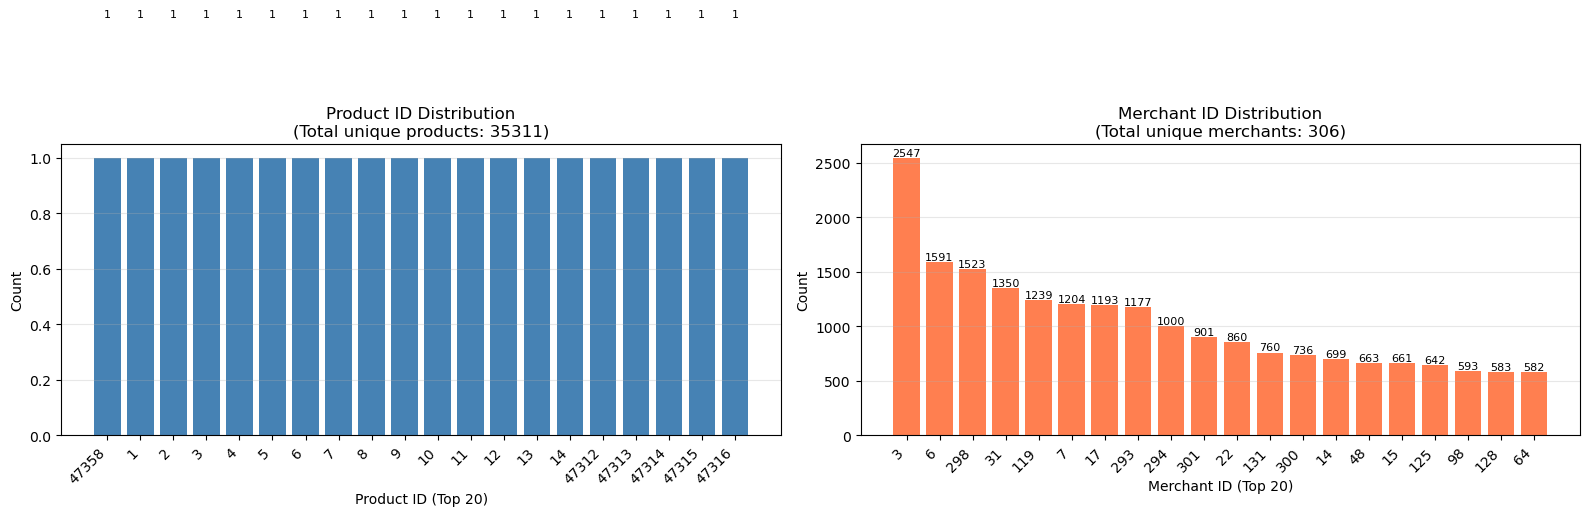


📊 Product ID Statistics:
   Total products: 35311
   Unique Product IDs: 35311
   Most common Product ID: 47358 (appears 1 times)
   Products appearing only once: 35311

📊 Merchant ID Statistics:
   Total entries: 35311
   Unique Merchant IDs: 306
   Most common Merchant ID: 3 (appears 2547 times)
   Merchants appearing only once: 40


In [2]:
# Bar plots for Product ID and Merchant ID distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Product ID distribution
ax1 = axes[0]
product_id_counts = product['Product ID'].value_counts().head(20)  # Top 20 products
ax1.bar(range(len(product_id_counts)), product_id_counts.values, color='steelblue')
ax1.set_xlabel('Product ID (Top 20)')
ax1.set_ylabel('Count')
ax1.set_title(f'Product ID Distribution\n(Total unique products: {product["Product ID"].nunique()})')
ax1.set_xticks(range(len(product_id_counts)))
ax1.set_xticklabels(product_id_counts.index, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(product_id_counts.values):
    ax1.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)

# Merchant ID distribution
ax2 = axes[1]
merchant_id_counts = product[' Merchant ID'].value_counts().head(20)  # Top 20 merchants
ax2.bar(range(len(merchant_id_counts)), merchant_id_counts.values, color='coral')
ax2.set_xlabel('Merchant ID (Top 20)')
ax2.set_ylabel('Count')
ax2.set_title(f'Merchant ID Distribution\n(Total unique merchants: {product[" Merchant ID"].nunique()})')
ax2.set_xticks(range(len(merchant_id_counts)))
ax2.set_xticklabels(merchant_id_counts.index, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(merchant_id_counts.values):
    ax2.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Product ID Statistics:")
print(f"   Total products: {len(product)}")
print(f"   Unique Product IDs: {product['Product ID'].nunique()}")
print(f"   Most common Product ID: {product_id_counts.index[0]} (appears {product_id_counts.values[0]} times)")
print(f"   Products appearing only once: {(product['Product ID'].value_counts() == 1).sum()}")

print("\n📊 Merchant ID Statistics:")
print(f"   Total entries: {len(product)}")
print(f"   Unique Merchant IDs: {product[' Merchant ID'].nunique()}")
print(f"   Most common Merchant ID: {merchant_id_counts.index[0]} (appears {merchant_id_counts.values[0]} times)")
print(f"   Merchants appearing only once: {(product[' Merchant ID'].value_counts() == 1).sum()}")

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
# TF-IDF handles tokenization automatically and gives more weight to rare, informative words
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,  # Limit to top 500 features to manage dimensionality
    min_df=2,          # Ignore terms that appear in fewer than 2 documents
    max_df=0.8         # Ignore terms that appear in more than 80% of documents
)

# Fit and transform the product titles directly (no manual tokenization needed!)
product_title_encoded = tfidf_vectorizer.fit_transform(product['Product Title'])

print(f"Encoding Statistics:")
print(f"Original titles: {len(product)}")
print(f"Encoded shape: {product_title_encoded.shape}")
print(f"  - {product_title_encoded.shape[0]} documents")
print(f"  - {product_title_encoded.shape[1]} features (unique tokens)")
print(f"\nVocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Sparsity: {(1.0 - product_title_encoded.nnz / (product_title_encoded.shape[0] * product_title_encoded.shape[1])) * 100:.2f}%")

# Show sample feature names
print(f"\nSample features (tokens): {list(tfidf_vectorizer.get_feature_names_out())[:20]}")

Encoding Statistics:
Original titles: 35311
Encoded shape: (35311, 500)
  - 35311 documents
  - 500 features (unique tokens)

Vocabulary size: 500
Sparsity: 98.78%

Sample features (tokens): ['10', '1000', '1080p', '10kg', '11', '1151', '12', '1200', '1200rpm', '128gb', '12mb', '13', '13ghz', '14', '1400', '1400rpm', '15', '1500', '16', '1600']


In [4]:
# Sample sizes to evaluate (values > dataset length are skipped). You can add 'full' below to force full dataset.
min_sample_size = [10, 50, 100, 500, 1000, 2000, 5000]

# HDBSCAN sweep for min_cluster_size
min_cluster_size = [5, 10, 20, 40, 80, 120]

In [5]:
results = []
count = 1
total = len(min_cluster_size)*len(min_sample_size)
print("Starting grid search...\n")

labels = product[" Cluster ID"].to_numpy()

for idx1, sample_size in enumerate(min_sample_size, 1):
    for idx2, min_size in enumerate(min_cluster_size, 1):
        
        print(f"\n[{count}/{total}] Testing min_sample_size {sample_size} and min_cluster_size={min_size}...", end=" ")
        
        # Fit HDBSCAN
        hdbscan = HDBSCAN(min_samples=sample_size, min_cluster_size=min_size, n_jobs=-1)
        clusters = hdbscan.fit_predict(product_title_encoded)

        # Calculate metrics
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        noise_pct = (n_noise / len(clusters)) * 100
    
        # Calculate ARI and NMI
        if n_clusters > 0:
            ari = adjusted_rand_score(labels, clusters)
            nmi = normalized_mutual_info_score(labels, clusters)
        
        else:
            ari = np.nan
            nmi = np.nan
    
        results.append({
            'min_sample_size' : sample_size,
            'min_cluster_size': min_size,
            'n_clusters': n_clusters,
            'noise_count': n_noise,
            'noise_pct': noise_pct,
            'ari': ari,
            'nmi': nmi,
        })
    
        print(f"\n✓ Clusters: {n_clusters}, Noise: {noise_pct:.1f}%, ARI: {ari:.4f}, NMI: {nmi:.4f}")
        count = count + 1

print("\n✓ Grid search complete!")

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ari', ascending=False)

print(f"\nTop 10 configurations by ARI:")
print(results_df.head(6).to_string(index=False))

print(f"\nTop 10 configurations by NMI:")
print(results_df.sort_values('nmi', ascending=False).head(6).to_string(index=False))

Starting grid search...


[1/42] Testing min_sample_size 10 and min_cluster_size=5... 
✓ Clusters: 777, Noise: 55.7%, ARI: 0.0001, NMI: 0.4540

[2/42] Testing min_sample_size 10 and min_cluster_size=10... 
✓ Clusters: 573, Noise: 57.0%, ARI: 0.0001, NMI: 0.4360

[3/42] Testing min_sample_size 10 and min_cluster_size=20... 
✓ Clusters: 274, Noise: 58.3%, ARI: 0.0001, NMI: 0.3938

[4/42] Testing min_sample_size 10 and min_cluster_size=40... 
✓ Clusters: 134, Noise: 53.6%, ARI: 0.0002, NMI: 0.3658

[5/42] Testing min_sample_size 10 and min_cluster_size=80... 
✓ Clusters: 52, Noise: 54.8%, ARI: 0.0002, NMI: 0.3160

[6/42] Testing min_sample_size 10 and min_cluster_size=120... 
✓ Clusters: 33, Noise: 53.4%, ARI: 0.0002, NMI: 0.2949

[7/42] Testing min_sample_size 50 and min_cluster_size=5... 
✓ Clusters: 435, Noise: 62.0%, ARI: 0.0001, NMI: 0.3349

[8/42] Testing min_sample_size 50 and min_cluster_size=10... 
✓ Clusters: 164, Noise: 63.6%, ARI: 0.0001, NMI: 0.2956

[9/42] Testing min_sample

In [10]:
print(f"\nTop 10 configurations by n_clusters:")
print(results_df.sort_values('n_clusters', ascending=True).head(40).to_string(index=False))


Top 10 configurations by n_clusters:
 min_sample_size  min_cluster_size  n_clusters  noise_count  noise_pct          ari      nmi
            2000                80           2        28161  79.751352 2.865461e-05 0.063963
            5000               120           2           22   0.062304 1.106775e-05 0.037069
            5000                80           2           22   0.062304 1.106775e-05 0.037069
            1000               120           2        24834  70.329359 5.798024e-05 0.076844
            1000                80           2           44   0.124607 1.024303e-06 0.005254
            2000                40           2          428   1.212087 1.735755e-06 0.012511
            1000                40           3         2066   5.850868 7.538749e-06 0.035366
            5000                40           3           60   0.169919 1.183078e-05 0.040615
            2000               120           3        33070  93.653536 2.500107e-06 0.039253
            1000                

From the above, the best parameters are min_sample_size: 5000  min_cluster_size: 5 which give the highest value for ARI and NMI.
However, for parameters that give a reasonable number of clusters, min_sample_size: 10  min_cluster_size: 120 would be more ideal.